# Template for analyzing the CLM5-PPE
- Updated Jan 27, 2023
- Daniel Kennedy, djk2120@ucar.edu

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib.pyplot as plt
import cftime
import dask
import statsmodels.api as sm
import seaborn as sns

In [2]:
### import some analysis functions we wrote for this project
import sys ; sys.path.append("..")
from ppe_analysis.analysis import *

In [3]:
import panel as pn
import param
pn.extension()

## spin up some extra cores on CASPER

In [64]:
# Setup your PBSCluster
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='25GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    project='P93300641', # Input your project ID here
    walltime='00:30:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(30)

# Setup your client
client = Client(cluster)

/glade/work/djk2120/miniconda3/envs/ppe-py/lib/python3.7/site-packages/distributed/node.py:161: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38911 instead
  f"Port {expected} is already in use.\n"


In [65]:
client.cluster

### OAAT: monthly h0 data

In [58]:
exps=['CTL2010','C285','C867','AF1855','AF2095','NDEP']
dvs=['TLAI','GPP','FCTR','SOILWATER_10CM']
dsets = {exp:get_exp(exp,dvs=dvs) for exp in exps}

120
120
120
120
120
120


In [68]:
#conversion factors
cfs={'PREC':{'cf1':24*60*60,'cf2':None},
     'GPP': {'cf1':24*60*60,'cf2':1e-9},
     'NBP': {'cf1':24*60*60,'cf2':1e-9},
     'FAREA_BURNED': {'cf1':24*60*60,'cf2':1}}
units={'PREC':'mm/d',
       'GPP':'PgC/yr',
       'NBP':'PgC/yr',
       'FAREA_BURNED':'km2'}
for v in ['FCTR','SOILWATER_10CM','TLAI']:
    cfs[v]={'cf1':1/365,'cf2':None}
    units[v]=dsets['CTL2010'][v].attrs['units']

In [72]:
la=dsets['CTL2010'].la
def agmean(exp,dv):
    return amean(gmean(dsets[exp][dv],la,cf=cfs[dv]['cf2']),cf=cfs[dv]['cf1']).mean(dim='year').compute()

In [74]:
%%time
expdim=xr.DataArray(exps,dims='exp')
ds=xr.Dataset(
    {dv:xr.concat([agmean(exp,dv) for exp in exps],dim=expdim) for dv in dvs}
    )
ds['param']=dsets['CTL2010'].param
ds['minmax']=dsets['CTL2010'].minmax

CPU times: user 51.4 s, sys: 2.09 s, total: 53.5 s
Wall time: 2min 12s


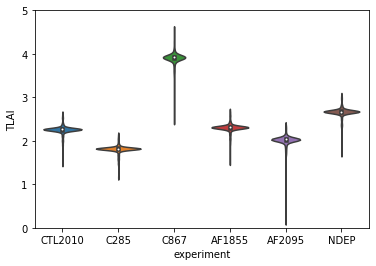

In [75]:
d={'TLAI':ds.TLAI.values.ravel(),
   'experiment':np.concatenate([np.tile(exp,len(ds.ens)) for exp in exps])}
df=pd.DataFrame(d)
sns.violinplot(data=df,x='experiment',y='TLAI')
plt.ylim([0,5]);

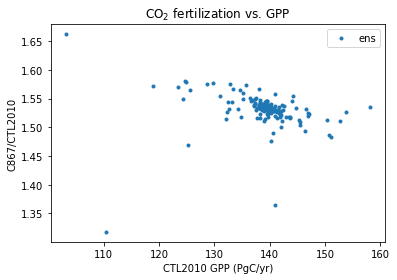

In [76]:
plt.plot(ds.GPP.sel(exp='CTL2010'),ds.GPP.sel(exp='C867')/ds.GPP.sel(exp='CTL2010'),'.',label='ens')
plt.xlabel('CTL2010 GPP (PgC/yr)')
plt.ylabel('C867/CTL2010')
plt.legend()
plt.title(r'CO$_2$ fertilization vs. GPP');

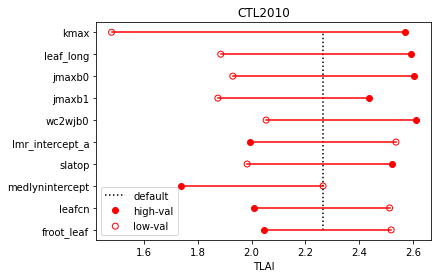

In [77]:
exp='CTL2010'
v='TLAI'
rank_plot(ds.TLAI.sel(exp=exp),ds,10)
plt.title(exp)
plt.xlabel('TLAI')
plt.legend(loc=3);

### OAAT: monthly h1 data

In [80]:
dvs=['TLAI']
ds=get_exp('CTL2010',dvs=dvs,tape='h1')

In [81]:
da=amean(ds.TLAI).mean(dim='year').compute()
dapft=gmean(da,ds.lapft,g=ds.pft)
ds=xr.Dataset()
ds['TLAI']=dapft
ds['param']=ds0.param
ds['minmax']=ds0.minmax
ds['pft_name']=ds0.pft_name

In [82]:
df=pd.DataFrame({'TLAI':dapft.values.T.ravel(),
    'pft':np.concatenate([np.tile(p,len(ds.ens)) for p in ds.pft_name.values])})

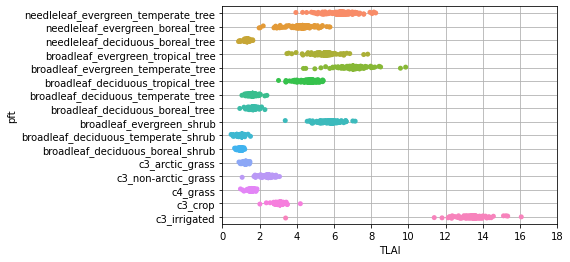

In [83]:
sns.stripplot(data=df,x='TLAI',y='pft')
plt.xlim([0,18])
plt.ylim([16.5,0.5])
plt.grid();

In [84]:
def rp(ds,p1,p2):
    
    fig = plt.Figure(figsize=[7,4])
    ax1=fig.add_subplot(121)
    ax2=fig.add_subplot(122)
    
    for p,ax in zip([p1,p2],[ax1,ax2]):
        da=ds.TLAI.sel(pft=p)
        rank_plot(da,ds,10,ax=ax)
        ax.set_title(ds.pft_name.sel(pft_id=p).values,fontsize=10)
        ax.set_xlabel('TLAI')
    
    fig.subplots_adjust(left=0.2,wspace=0.7)
    
    return fig

In [85]:
class Parameters(param.Parameterized):
    PFT1  = param.Integer(default=1, bounds=(1, 17))
    PFT2  = param.Integer(default=2, bounds=(1, 17))

    def view(self):
        return rp(ds,self.PFT1,self.PFT2)

obj = Parameters()
obj

Parameters(PFT1=1, PFT2=2, name='Parameters00101')

Row
    [0] ParamMethod(method)
    [1] Column(margin=5, name='Parameters', width=300)
        [0] StaticText(value='<b>Parameters</b>')
        [1] IntSlider(end=17, name='PFT1', start=1, value=1)
        [2] IntSlider(end=17, name='PFT2', start=1, value=2)
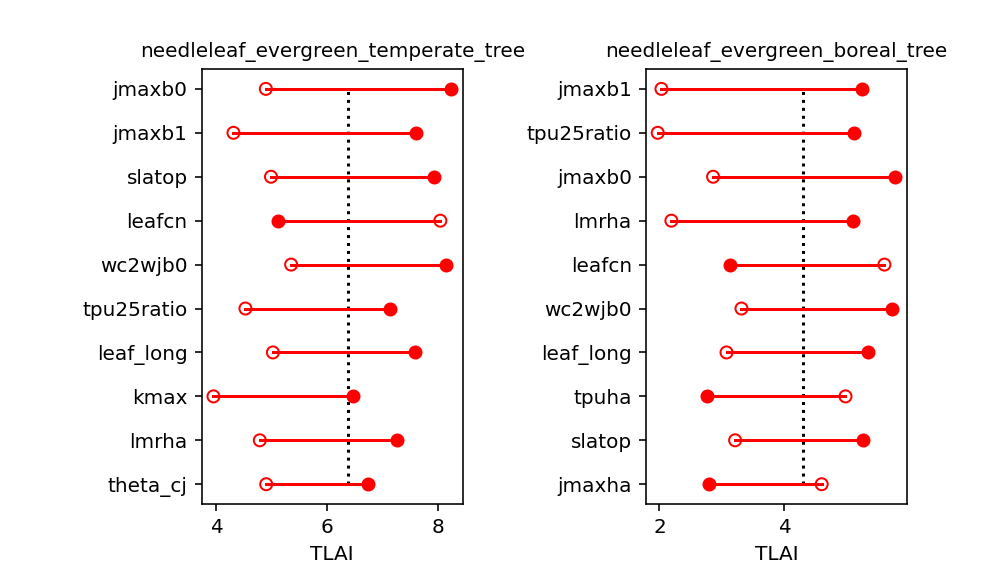

In [86]:
pn.Row(obj.view,obj.param)

### latin hypercube

In [300]:
ds=get_exp('transient',dvs=['TLAI'],yy=(2005,2014))

In [302]:
da=amean(gmean(ds.TLAI,ds.la)).mean(dim='year')

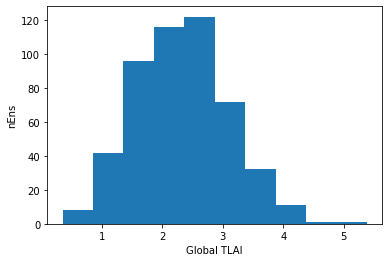

In [306]:
plt.hist(da)
plt.xlabel('Global TLAI')
plt.ylabel('nEns');